#Library

In [ ]:
# Mount Google Drive to access the dataset stored in Drive
from google.colab import drive
drive.mount('/content/drive')

# Import TensorFlow and enable eager execution for immediate execution of operations
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

# Import necessary libraries for data handling and manipulation
import os
import sys
import random
import warnings
import pandas as pd
import math
import cv2
import skimage
from skimage import data, io
import datetime
from math import *
from matplotlib import pyplot
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (BatchNormalization, Conv2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D,
                                     UpSampling2D, Conv2DTranspose, ELU, Activation, Flatten, Dropout, Dense,
                                     ZeroPadding2D, Concatenate, Input)
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import regularizers
import imgaug as ia
from imgaug import augmenters as iaa
import albumentations as A
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from shutil import copyfile
import seaborn as sn
from tensorflow.keras.preprocessing import image
from os.path import isfile, join
import re
from tensorflow.keras.preprocessing.image import img_to_array
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import custom modules (My Proposed Functions), Download from GitHub and Import Here
from ASoftMax import my_forward
from AADAM import ArminAdam
from ALoss import MyLoss
from AClass_Weight import create_class_weight

# LOAD DATA

In [ ]:
np.random.seed(20)

In [ ]:
# Load data from .mat files using scipy's loadmat method

train_raw = loadmat('train_32x32.mat')
test_raw = loadmat('test_32x32.mat')

In [ ]:
# Extract images and labels from the loaded data
train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']

In [ ]:
# Preprocess data: Fix axes of images, convert data types, and one-hot encode labels
train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)
train_images = train_images.astype('float64')
test_images = test_images.astype('float64')
train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


In [ ]:
# Split data into training, validation, and testing sets

x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.15, random_state=22)

# IMAGE GENERATOR

In [ ]:
num_classes = 10
batch_size =64

# Define data augmentation strategies for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./512, rotation_range=20, shear_range=0.2, zoom_range=0.2)
validation_datagen = ImageDataGenerator(rescale=1./512)

# Prepare data generators for training and validation
train_generator = train_datagen.flow(x_train, y_train, batch_size=64, shuffle=True)
validation_generator = validation_datagen.flow(x_val, y_val, batch_size=64, shuffle=True)

# MODEL

## Side Branch

In [ ]:
l2=tf.keras.regularizers.l2(1e-3)
kernel_init = tf.keras.initializers.he_normal()
bias_init = tf.keras.initializers.Constant(value=0.1)

In [ ]:
 def auxilliary_module1(x,
                     filters_3x3,
                     filters_3x3_1,
                     filters_3x3_2,
                     filters_5x5,
                     filters_5x5_1,
                     filters_5x5_2,
                     filters_pool_proj,
                     name='aux1'):

    conv_3x3 = Conv2D(filters_3x3, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(x)
    conv_3x3_1 = Conv2D(filters_3x3_1, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal")(conv_3x3)
    conv_3x3_2 = Conv2D(filters_3x3_2, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal",kernel_regularizer=l2)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
    conv_5x5_1= Conv2D(filters_5x5_1, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal")(conv_5x5)
    conv_5x5_2 = Conv2D(filters_5x5_2, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal",kernel_regularizer=l2)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(pool_proj)

    output = concatenate([conv_3x3_1, conv_3x3_2, conv_5x5_1,conv_5x5_2, pool_proj], axis=3, name='aux1')

    return output

In [ ]:
 def auxilliary_module2(x,
                     filters_3x3,
                     filters_3x3_1,
                     filters_3x3_2,
                     filters_5x5,
                     filters_5x5_1,
                     filters_5x5_2,
                     filters_pool_proj,
                     name='aux2'):

    conv_3x3 = Conv2D(filters_3x3, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(x)
    conv_3x3_1 = Conv2D(filters_3x3_1, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal")(conv_3x3)
    conv_3x3_2 = Conv2D(filters_3x3_2, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal",kernel_regularizer=l2)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init)(x)
    conv_5x5_1= Conv2D(filters_5x5_1, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal")(conv_5x5)
    conv_5x5_2 = Conv2D(filters_5x5_2, (5, 5), padding='same', activation='relu', kernel_initializer="he_normal",kernel_regularizer=l2)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer="he_normal")(pool_proj)

    output = concatenate([conv_3x3_1, conv_3x3_2, conv_5x5_1,conv_5x5_2, pool_proj], axis=3, name='aux2')

    return output

## Main Branch

In [ ]:
model = Sequential()
input_layer = Input(shape=(32,32,3))

#############################################
input_half_1 = AveragePooling2D(pool_size=(2, 2), padding='valid')(input_layer)
########################################
x_0=Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal")(input_layer)
x=Activation('elu')(x_0)
x=BatchNormalization(name='batch_10')(x)

x=Conv2D(64, (1,1), padding = "same", kernel_initializer="he_normal")(x)

x=Conv2D(64, (3,3), padding = "same", kernel_initializer="he_normal")(x)
x=Activation('elu')(x)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)

x=Conv2D(64, (3,3), padding = "same", kernel_initializer="he_normal")(x)
x=Activation('elu')(x)
x=BatchNormalization()(x)

x0=AveragePooling2D(pool_size=(2, 2))(x)
y1=AveragePooling2D(pool_size=(4, 4))(x)
y1=Dropout(0.2)(y1)

x1= concatenate([x0, input_half_1])
##############################################
i0=Conv2D(64, (1,1), padding = "same", kernel_initializer="he_normal")(x1)

i1 = inception_module1(i0,
                     filters_3x3=128,
                     filters_3x3_1=192,
                     filters_3x3_2=192,
                     filters_5x5=64,
                     filters_5x5_1=96,
                     filters_5x5_2=96,
                     filters_pool_proj=64,
                     name='inc1')

i2 = inception_module2(i1,
                     filters_3x3=128,
                     filters_3x3_1=192,
                     filters_3x3_2=192,
                     filters_5x5=64,
                     filters_5x5_1=96,
                     filters_5x5_2=96,
                     filters_pool_proj=64,
                     name='inc2')

i4 = AveragePooling2D(pool_size=(3, 3), padding='same')(i2)

##############################################
x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal")(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization()(x1)

x1=Conv2D(128, (1,1), padding = "same", kernel_initializer="he_normal")(x1)


x1=ZeroPadding2D((1, 1))(x1)
x1=Conv2D(128, (3, 3), padding = 'same', kernel_initializer="he_normal")(x1)
x1=Activation('elu')(x1)
x1=BatchNormalization(name='batch_12')(x1)

x12=Conv2D(128, (3, 3), padding = 'valid', kernel_initializer="he_normal")(x1)
x1=Activation('elu')(x1)
x23=BatchNormalization()(x1)
x23=Dropout(0.2) (x23)
x23= MaxPooling2D(pool_size=(3,3))(x23)

x21= AveragePooling2D(pool_size=(2, 2))(x12)


x2=concatenate([y1,x21])
#############################

x3=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal")(x2)
x3=Activation('elu')(x3)
x35=BatchNormalization()(x3)

x34=Conv2D(256, (1,1), padding = "same", kernel_initializer="he_normal")(x35)

x36=Conv2D(256, (3, 3), padding = 'same', kernel_initializer="he_normal")(x34)
x36=Activation('elu')(x36)
x3166=BatchNormalization()(x36)
x3166=Dropout(0.2)(x3166)
x316=ZeroPadding2D((2,2))(x3166)

x33= MaxPooling2D(pool_size=(2,2))(x316)

x3_1=AveragePooling2D(pool_size=(2, 2)) (x3166)

#########################################

x4=ZeroPadding2D((1, 1))(x3_1)
x4=Conv2D(512, (3, 3), padding = 'same', kernel_initializer="he_normal")(x4)
x4=Activation('elu')(x4)
x4=BatchNormalization()(x4)

x6=Conv2D(512, (1,1), padding = "same", kernel_initializer="he_normal")(x4)

x6=Conv2D(512, (3, 3), padding = 'valid', kernel_initializer="he_normal")(x6)
x6=Activation('elu')(x6)
x6=BatchNormalization()(x6)

x7 =AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x6)
#####################

dc_1_0 = Conv2DTranspose(512, (5,5), activation='elu',strides=1,
      padding = 'valid',kernel_initializer='he_normal')(x7)
x7 =ZeroPadding2D((2,2))(x7)
x7 = UpSampling2D((4,4))(x7)
dc_1_0=concatenate([i4,dc_1_0,x23,x33])
dc_1 = UpSampling2D((2,2))(dc_1_0)

x7_0 = Flatten()(dc_1)

x7_1 = Dense(128, activation='elu')(x7_0)
x7_2 =BatchNormalization()(x7_1)
x7_2 = Dropout(0.2)(x7_2)
x7_4 = Dense(64, activation='elu')(x7_2)
x7_5 =BatchNormalization()(x7_4)
x7_5 = Dropout(0.1)(x7_5)
x8_1 = Dense(num_classes,kernel_initializer="he_normal")(x7_5)
x8 =Activation(my_forward,dynamic=True)(x8_1)

model = Model(input_layer, [x8])

# Hyperparameter Tuning Functions

In [ ]:
import datetime
weight_decay = 1e-6
momentum = 0.9
learning_rate = 0.001

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


def decay(epochs, steps=100):
    drop = 0.95
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+(2*epochs)/epochs_drop)))
    return lrate


initial_lrate = 0.0001
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2,
                              patience=4, min_lr=1e-6, verbose=0)

checkpoint = ModelCheckpoint("/svhn.h5",
                             #save the best model while all epovhs of training
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 1e-8,
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)

lr_sc = LearningRateScheduler(decay,verbose=1)


mycallback = [earlystop,checkpoint
              ,reduce_lr
              ,lr_sc
              ,create_tensorboard_callback(dir_name="tensorflow_hub",
                experiment_name="SVHN_Model")]

# TRAIN

In [ ]:
# Load Pre-Trained Weights: Refer to the README.md for the shared link.
model.load_weights("/svhn_armin.nabaei2_1.h5")

In [ ]:
model.compile(#loss='categorical_crossentropy',
                loss= MyLoss,
                optimizer = ArminAdam,
                #optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])


nb_train_samples = 73257
nb_validation_samples = 26032


# fit the model
history = model.fit_generator(train_generator,
                              epochs=20,
                              validation_data= validation_generator,
                              callbacks = mycallback,
                              verbose=1)

Saving TensorBoard log files to: tensorflow_hub/SVHN_Model/20240220-191630


<ipython-input-30-e196fb9a000f>:64: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,



Epoch 1: LearningRateScheduler setting learning rate to 9.5e-05.
Epoch 1/20
1145/1145 [==============================] - ETA: 0s - loss: 1.5630 - accuracy: 0.9638
Epoch 1: val_accuracy improved from -inf to 0.97695, saving model to /content/drive/MyDrive/svhn/svhn_armin.nabaei2_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1145/1145 [==============================] - 513s 441ms/step - loss: 1.5630 - accuracy: 0.9638 - val_loss: 1.5236 - val_accuracy: 0.9770 - lr: 9.5000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.5e-05.
Epoch 2/20
1145/1145 [==============================] - ETA: 0s - loss: 1.4979 - accuracy: 0.9765
Epoch 2: val_accuracy did not improve from 0.97695
1145/1145 [==============================] - 491s 429ms/step - loss: 1.4979 - accuracy: 0.9765 - val_loss: 1.5216 - val_accuracy: 0.9748 - lr: 9.5000e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.5e-05.
Epoch 3/20
1145/1145 [==============================] - ETA: 0s - loss: 1.4636 - accuracy: 0.9839
Epoch 3: val_accuracy did not improve from 0.97695
1145/1145 [==============================] - 490s 428ms/step - loss: 1.4636 - accuracy: 0.9839 - val_loss: 1.5514 - val_accuracy: 0.9751 - lr: 9.5000e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.5e-05.
Epoch 4/20
1145/1145 [====================


# Evaluation

In [ ]:
# Evaluate model on test data
results = model.evaluate(validation_generator,verbose=0, return_dict=True)
print("test loss, test acc:", results)


407/407 [==============================] - 26s 65ms/step - loss: 0.1158 - accuracy: 0.9765
test loss, test acc: {'loss': 0.1157761663198471, 'accuracy': 0.9764520525932312}


# Ploting our Loss and Accuracy Charts

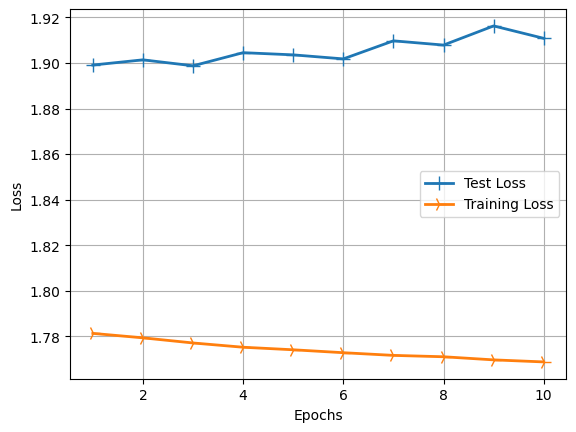

In [ ]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

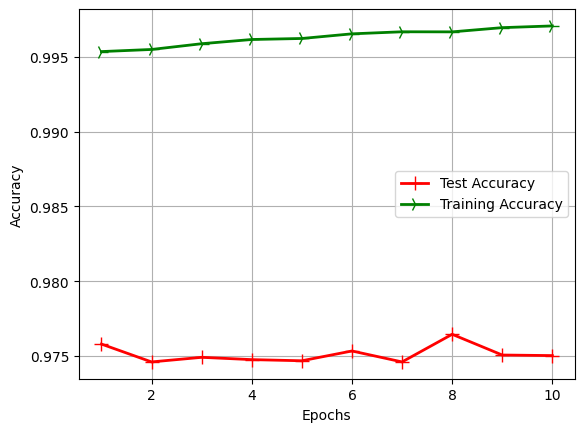

In [ ]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, color='r',label='Test Accuracy')
line2 = plt.plot(epochs, acc_values,color='g', label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Confusion Matrix

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5099
           1       0.98      0.98      0.98      4149
           2       0.97      0.96      0.97      2882
           3       0.97      0.98      0.98      2523
           4       0.98      0.97      0.97      2384
           5       0.96      0.97      0.97      1977
           6       0.96      0.97      0.97      2019
           7       0.96      0.97      0.97      1660
           8       0.95      0.97      0.96      1595
           9       0.96      0.97      0.97      1744

    accuracy                           0.97     26032
   macro avg       0.97      0.97      0.97     26032
weighted avg       0.97      0.97      0.97     26032



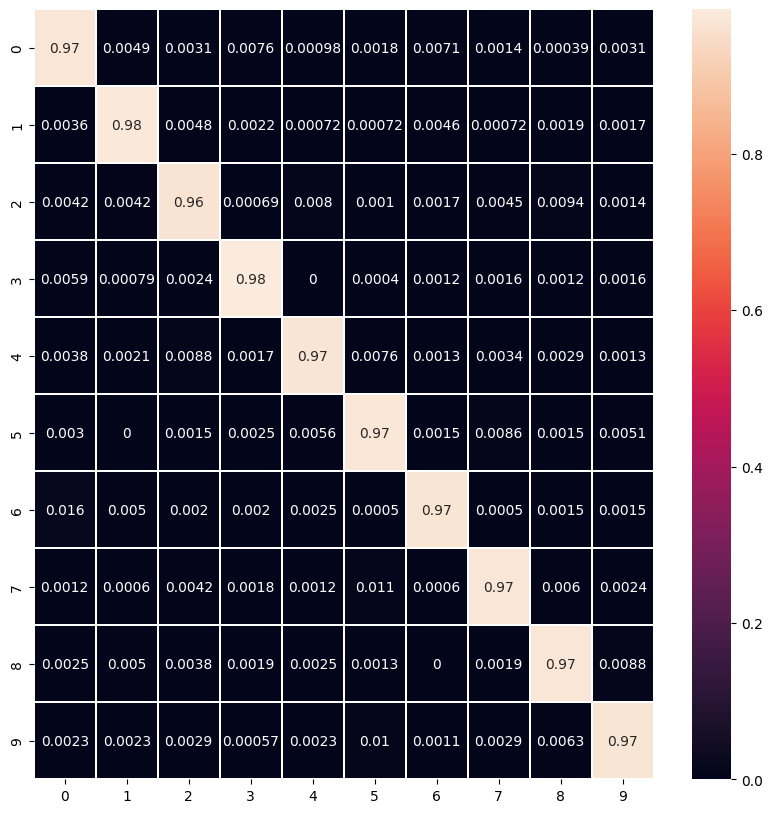

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns


class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
validation_generator = validation_datagen.flow(
        x_test, y_test,
        batch_size=batch_size,
        shuffle=False)
############################################
predictions  = model.predict(validation_generator, batch_size=64, verbose=0)
################################################
y_preds = [np.argmax(i) for i in predictions]
test_y = [np.argmax(i) for i in y_test]
#The following 7 lines are all that is required to plot the confusion matrix.
#predictions_for_cm = predictions.argmax(1)

#################################

cnf_matrix = confusion_matrix(test_y,y_preds)
plt.figure(figsize=(10,10))
#sns.heatmap(cnf_matrix, annot=True,  xticklabels=class_names, yticklabels = class_names,center=0, fmt="d",vmin=0, vmax=1)
#Create normalized Confusion Matrix
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True,  linewidths = 0.01)
print(classification_report(test_y,y_preds))